In [11]:
import numpy as np
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from openTSNE import TSNE

import sys

sys.path.append("../code")

import sparseRRR
import simulator
from simulator import EphysModel
from rnaseqTools import geneSelection
from plot_utils import adjust_spines

%load_ext jupyter_black

In [13]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2024-11-28 16:06:54WET

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

torch     : 2.3.0
xarray    : 2023.6.0
seaborn   : 0.12.2
sys       : 3.11.7 (main, Dec 15 2023, 12:09:56) [Clang 14.0.6 ]
json      : 2.0.9
pandas    : 2.1.4
numpy     : 1.26.4
ipywidgets: 7.6.5
matplotlib: 3.8.0

Watermark: 2.4.3



### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [16]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [18]:
ephys_features_w_units = np.array(
    [
        "AP threshold (mV)",
        "AP amplitude (mV)",
        "AP width (ms)",
        "AHP (mV)",
        "3rd AP threshold (mV)",
        "3rd AP amplitude (mV)",
        "3rd AP width (ms)",
        "3rd AHP (mV)",
        "AP count",
        "AP count 1st 8th",
        "AP count 1st quarter",
        "AP count 1st half",
        "AP count 2nd half",
        "AP amp adapt",
        "AP average amp adapt",
        "AP CV",
        "ISI adapt",
        "ISI CV",
        "Latency (ms)",
        "rest $V_{m}$ mean (mV)",
        "$V_{m}$ mean (mV)",
        "$V_{m}$ std (mV)",
        "$V_{m}$ skewness",
    ],
    dtype=object,
)

In [20]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [22]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [24]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [26]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Figure 8

Average family simulations on the tSNE

We load gene expression levels and first keep 1000 most variable genes for tSNE. 

In [31]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names

Chosen offset: 7.53


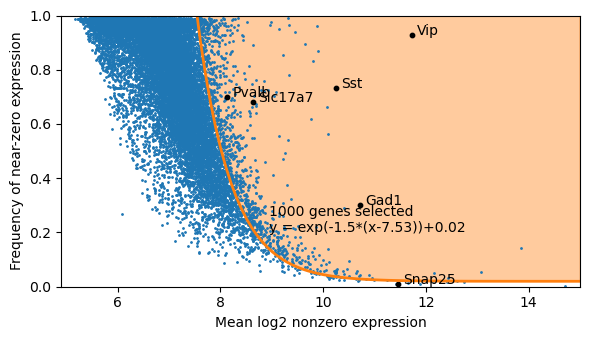

In [32]:
amount_of_genes = 1000
markerGenes = ["Snap25", "Gad1", "Slc17a7", "Pvalb", "Sst", "Vip"]
selectedGenes = geneSelection(
    exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names
)
exonCounts = exonCounts[:, selectedGenes]
gene_names = gene_names[selectedGenes]

In [33]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

In [34]:
# load tsne embedding coordinates
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [37]:
# Allen data t-type ordering:
allen = pickle.load(open("../data/SmartSeq_cells_AIBS.pickle", "rb"))
clusterNames = allen["neurons"]["clusterNames"]

WARNING    /var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_2864/4175803554.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  allen = pickle.load(open("../data/SmartSeq_cells_AIBS.pickle", "rb"))
 [py.warnings]
  allen = pickle.load(open("../data/SmartSeq_cells_AIBS.pickle", "rb"))



In [42]:
clusterNames[np.where(clusterNames == "L5 PT_1")[0]] = "L5 ET_1"
clusterNames[np.where(clusterNames == "L5 PT_2")[0]] = "L5 ET_2"
clusterNames[np.where(clusterNames == "L5 PT_3")[0]] = "L5 ET_3"
clusterNames[np.where(clusterNames == "L5 PT_4")[0]] = "L5 ET_4"

In [44]:
ttypes = []
for ttype in clusterNames:
    if ttype in celltypes.values:
        ttypes.append(ttype)
ttypes = np.array(ttypes)

In [46]:
fav_tr_schedule = "2d"

In [48]:
with open(
    "../code/save_model_parameters/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

In [50]:
highest_posterior_samples_standardized = (
    highest_posterior_samples - highest_posterior_samples.mean(axis=0)
) / highest_posterior_samples.std(axis=0)

In [51]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T

In [52]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv(
    "../data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in data_exons.index
    ]
)
enough_counts = np.sum(data_exons, axis=1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [55]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

Load sRRR weights, either computed once in `figure_4_and_5.ipynb` or already saved.

In [57]:
# load sRRR weights
w = np.load("./embedding_coordinates/sRRR.npz")["w"]
v = np.load("./embedding_coordinates/sRRR.npz")["v"]

In [59]:
M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

In [60]:
npen_sims = [
    M1_model._run_HH_model(highest_posterior_samples[celltype.values, :].mean(axis=0))
    for celltype in [
        celltype_Pvalb,
        celltype_Lamp5,
        celltype_Sst,
        celltype_Pyr,
        celltype_Vip,
        celltype_Sncg,
    ]
]

INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


In [61]:
npen_xs = np.array([M1_model._calculate_summary_statistics(x)[0] for x in npen_sims])

In [63]:
sRRR_sims = [
    M1_model._run_HH_model(
        ((G @ w @ v.T)[celltype.values, :].mean(axis=0))
        * highest_posterior_samples.std(axis=0)
        + highest_posterior_samples.mean(axis=0)
    )
    for celltype in [
        celltype_Pvalb,
        celltype_Lamp5,
        celltype_Sst,
        celltype_Pyr,
        celltype_Vip,
        celltype_Sncg,
    ]
]

In [64]:
sRRR_xs = np.array([M1_model._calculate_summary_statistics(x)[0] for x in sRRR_sims])

In [65]:
# Get average family simulations, from fitting with sbip
x_Pvalb = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Pvalb.values, :].mean(axis=0)
)
x_Vip = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Vip.values, :].mean(axis=0)
)
x_Sst = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Sst.values, :].mean(axis=0)
)
x_Lamp5 = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Lamp5.values, :].mean(axis=0)
)
x_Pyr = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Pyr.values, :].mean(axis=0)
)
x_Sncg = M1_model._run_HH_model(
    highest_posterior_samples[celltype_Sncg.values, :].mean(axis=0)
)

In [66]:
# Get average family simulations, from utilizing genes and predicting fitted model parameter distributions
# with sRRR (for entire dataset, based on good cv results)
x_g_Pvalb_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Pvalb.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)
x_g_Vip_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Vip.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)
x_g_Sst_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Sst.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)
x_g_Lamp5_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Lamp5.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)
x_g_Pyr_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Pyr.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)
x_g_Sncg_sRRR = M1_model._run_HH_model(
    ((G @ w @ v.T)[celltype_Sncg.values, :].mean(axis=0))
    * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
)

In [67]:
def create_figure_8(fig):
    if fig is None:
        fig = plt.figure(figsize=(9, 3))
    else:
        fig = fig
    width, height = 0.16, 0.12

    ax_exps = [
        plt.axes([0, 0.05, width, height]),
        plt.axes([0.22, 0.66, width, height], zorder=1),
        plt.axes([0, 0.4, width, height]),
        plt.axes([0.28, 0.2, width, height], zorder=1),
        plt.axes([0.02, 0.75, width, height]),
        plt.axes([0.15, 0, width, height]),
    ]
    ax_sims = [
        plt.axes([0, 0.18, width, height]),
        plt.axes([0.22, 0.79, width, height], zorder=1),
        plt.axes([0, 0.53, width, height]),
        plt.axes([0.28, 0.33, width, height], zorder=1),
        plt.axes([0.02, 0.88, width, height]),
        plt.axes([0.15, 0.13, width, height]),
    ]
    ax_embed = plt.axes([0.15, 0.3, 0.15, 0.45])
    ax_features = [
        [plt.axes([x, y, 0.07, 0.21]) for y in [0, 0.38, 0.76]]
        for x in [0.48, 0.61, 0.74]
    ]
    return ax_embed, ax_exps, ax_sims, ax_features

In [68]:
features_to_show = [3, 4, 8, 21, 12, 15, 17, 18, 20]

In [71]:
exps_colors = ["darkred", "salmon", "goldenrod", "lightseagreen", "purple", "darkgrey"]

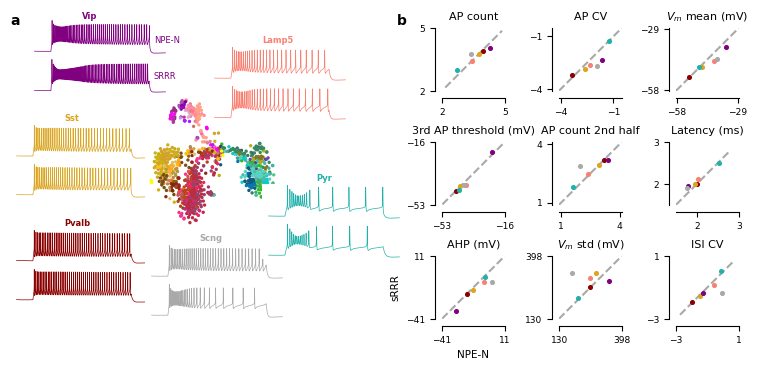

In [83]:
fig = plt.figure(figsize=(9, 3))
ax_embed, ax_exps, ax_sims, ax_features = create_figure_8(fig)
ax_embed.scatter(Z[:, 0], Z[:, 1], s=2, c=colors)
ax_embed.set_xticks([])
ax_embed.set_yticks([])
sns.despine(ax=ax_embed, left=True, bottom=True)
for i, ax in enumerate(ax_exps):
    # MAP simulations with NPE-N
    ax.plot(
        npen_sims[i]["time"],
        npen_sims[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

for i, ax in enumerate(ax_sims):
    # sRRR simulation predictions based on genes
    ax.plot(
        sRRR_sims[i]["time"],
        sRRR_sims[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)


for i, ax in enumerate(np.array(ax_features).reshape(-1)):
    for j in range(6):
        ax.scatter(
            npen_xs[j, features_to_show[i]],
            sRRR_xs[j, features_to_show[i]],
            color=exps_colors[j],
            s=7,
        )
    std = npen_xs[:, features_to_show[i]].std()
    ax.plot(
        [
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        ],
        [
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        ],
        "--",
        c="darkgrey",
        zorder=0,
    )
    ax.set_xlim(
        (
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_ylim(
        (
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_xticks(
        [
            round(npen_xs[:, features_to_show[i]].min() - 1.1 * std),
            round(npen_xs[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    ax.set_yticks(
        [
            round(npen_xs[:, features_to_show[i]].min() - 1.1 * std),
            round(npen_xs[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    if i == 0:
        ax.set_xlabel("NPE-N", fontsize=7.5)
        ax.set_ylabel("sRRR", fontsize=7.5)
    ax.tick_params(which="both", labelsize=6.5)
    ax.set_title(ephys_features_w_units[features_to_show[i]], fontsize=8)
    adjust_spines(ax, ["left", "bottom"])
    sns.despine(ax=ax)

fs = 6
fig.text(0.16, 0.92, "NPE-N", fontsize=fs, color="purple")
fig.text(0.16, 0.8, "SRRR", fontsize=fs, color="purple")
fig.text(0.06, 0.31, "Pvalb", fontsize=fs, color="darkred", fontweight="bold")
fig.text(0.28, 0.92, "Lamp5", fontsize=fs, color="salmon", fontweight="bold")
fig.text(0.06, 0.66, "Sst", fontsize=fs, color="goldenrod", fontweight="bold")
fig.text(0.08, 1, "Vip", fontsize=fs, color="purple", fontweight="bold")
fig.text(0.34, 0.46, "Pyr", fontsize=fs, color="lightseagreen", fontweight="bold")
fig.text(0.21, 0.26, "Scng", fontsize=fs, color="darkgrey", fontweight="bold")
fig.text(0, 0.98, "a", fontsize=10, color="k", fontweight="bold")
fig.text(0.43, 0.98, "b", fontsize=10, color="k", fontweight="bold")

plt.savefig("figure_8.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_8.png", bbox_inches="tight", pad_inches=0)